In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pyCloudy as pc

In [18]:
import os
dir_ = os.environ['HOME'] + '/SIGNALS_models'
pc.print_make_file(dir_)

# Using Popstar models

`mkdir Popstar
cd Popstar
wget https://www.fractal-es.com/PopStar/docs/sp-cha-z0001.zip
wget https://www.fractal-es.com/PopStar/docs/sp-cha-z0004.zip
wget https://www.fractal-es.com/PopStar/docs/sp-cha-z0040.zip
wget https://www.fractal-es.com/PopStar/docs/sp-cha-z0080.zip
wget https://www.fractal-es.com/PopStar/docs/sp-cha-z0200.zip
wget https://www.fractal-es.com/PopStar/docs/sp-cha-z0500.zip
unzip sp-cha-z0001.zip
unzip sp-cha-z0004.zip 
unzip sp-cha-z0040.zip 
unzip sp-cha-z0080.zip 
unzip sp-cha-z0200.zip 
unzip sp-cha-z0500.zip
wget https://data.nublado.org/stars/convert_popstar.pl
chmod a+x convert_popstar.pl 
./convert_popstar.pl > spneb_cha.ascii
echo 'compile stars "spneb_cha.ascii"' | cloudy.exe
`

Copy the `spneb_cha.mod` file to your models directory. From this directory, you can explore the list of available parameters:

In [3]:
!cd ~/SIGNALS_models/; echo 'table star "spneb_cha.mod" list' | cloudy.exe

                                                          Cloudy 17.02
                                                         www.nublado.org

                       **************************************17Jun01**************************************
                       *                                                                                 *
                       * table star "spneb_cha.mod" list                                                 *

   Age\log(Z) |        -4      -3.4      -2.4      -2.1      -1.7      -1.3
--------------|------------------------------------------------------------
       100000 |        10       116       222       328       434       540
     301995.2 |        11       117       223       329       435       541
     501187.2 |        12       118       224       330       436       542
     707945.8 |        13       119       225       331       437       543
      1000000 |        14       120       226       332       438       544
 

In [56]:
# 
print(10**(np.array((-4, -3.4, -2.4, -2.1, -1.7, -1.3))+1.7))

[0.00501187 0.01995262 0.19952623 0.39810717 1.         2.51188643]


In [53]:
options = ('no molecules',
           'no level2 lines',
           'no fine opacities',
           'atom h-like levels small',
           'atom he-like levels small',
           'element limit off -7',
            )

from pyCloudy.utils.physics import abund_Nicholls_GC_2017_0020, abund_Nicholls_GC_2017_0200, \
                                   abund_Nicholls_GC_2017_0400, abund_Nicholls_GC_2017_1000, \
                                   abund_Nicholls_GC_2017_2100, abund_Nicholls_GC_2017_3000
ab_dict_sol = abund_Nicholls_GC_2017_1000
def get_R_in_Q0(logU, fr, NH=100, ff=1.0): # fr is a form factor. see Sec 4.1 of http://adsabs.harvard.edu/abs/2015A%26A...576A..83S
    c = pc.CST.CLIGHT
    U_mean = 10**logU
    w = (1 + fr**3.)**(1./3) - fr
    alpha_B = 2.6e-13
    Q0 = 4. * np.pi * c**3 * U_mean**3 / (3. * NH * ff**2 * alpha_B**2 * w**3)
    R_str = (3. * Q0 / (4 * np.pi * NH**2 * alpha_B * ff))**(1./3)
    R_in = fr * R_str
    return R_in, Q0

def make_mod(models_dir, generic_name, logU, Z, age):
    
    if Z not in ('0020', '0200', '0400', '1000', '2100', '3000'):
        raise ValueError('Wrong Z : {}'.format(Z))
    Z_Popstar = np.log10(float(Z)/1000) - 1.7
    if Z_Popstar > -1.31:
        Z_Popstar = -1.31
    if Z_Popstar < -3.99:
        Z_Popstar = -3.99
    name = '{}_{:4.1f}_{}_{:3.1f}'.format(generic_name, logU, Z, age/1e6)
    NH = 100
    ff = 0.1
    fr = 3.00
    R_in, Q0 = get_R_in_Q0(logU, fr=fr, NH=NH, ff=ff)
    c_input = pc.CloudyInput('{0}/{1}'.format(models_dir, name))
    c_input.set_star(SED='table star "spneb_cha.mod"', 
                     SED_params=(age, Z_Popstar),
                     lumi_unit = 'q(H)', lumi_value = np.log10(Q0))
    c_input.set_cste_density(np.log10(NH), ff = ff)
    c_input.set_radius(r_in = np.log10(R_in))
    ab_dict = eval("abund_Nicholls_GC_2017_{}".format(Z))
    c_input.set_abund(ab_dict = ab_dict)
    c_input.set_grains('ism {} '.format(ab_dict['O']-ab_dict_sol['O'])) # Not totally coherent...
    c_input.set_distance(dist=1., unit='kpc', linear=True)
    c_input.set_other(options)
    c_input.set_stop(('temperature off', 'pfrac 0.02'))
    # list of emission lines see: https://sites.google.com/site/mexicanmillionmodels/the-different-tables/lines
    c_input.set_emis_tab(['H  1 4861.33A', 
                          'H  1 6562.81A', 
                          'N  2 6583.45A', 
                          'O  2 3726.03A',
                          'O  2 3728.81A',                          
                          'O  3 5006.84A',
                          'S  2 6730.82A',
                          'S  2 6716.44A'])
    c_input.print_input()

In [22]:
make_mod(dir_, 'M5', logU=-2.5, Z='0200', age=2e6)

In [27]:
generic_name = 'M6'

In [54]:
for age in (1e6, 2e6, 3e6, 4e6, 5e6):
    for logU in np.arange(-3.5, -1.49, 0.5):
        for Z in ('0020', '0200', '0400', '1000', '2100', '3000'):
            make_mod(dir_, generic_name, logU, Z, age)

In [55]:
# This will run 150 models, take care of this ;-)
#pc.run_cloudy(dir_=dir_, n_proc=12, use_make=True, model_name=generic_name)

## Read all the models in a single list

In [57]:
Ms = pc.load_models('{}/{}'.format(dir_, generic_name))

## Extract the first model to have a look at it

In [58]:
M = Ms[0]

In [59]:
M.print_stats()

 Name of the model: /Users/christophemorisset/SIGNALS_models/M6_-1.5_0020_2.0
 R_in (cut) = 2.992e+22 (2.992e+22), R_out (cut) = 3.047e+22 (3.047e+22)
 H+ mass = 5.26e+10, H mass = 5.30e+10 N zones: 200
 <H+/H> = 1.00, <He++/He> = 0.00, <He+/He> = 1.00
 <O+++/O> = 0.00, <O++/O> = 0.98, <O+/O> = 0.02
 <N+++/N> = 0.47, <N++/N> = 0.51, <N+/N> = 0.02
 T(O+++) = 23025, T(O++) = 20854, T(O+) = 15886
 <ne> = 108,  <nH> = 100, T0 = 20751, t2=0.0057
 <log U> = -1.50


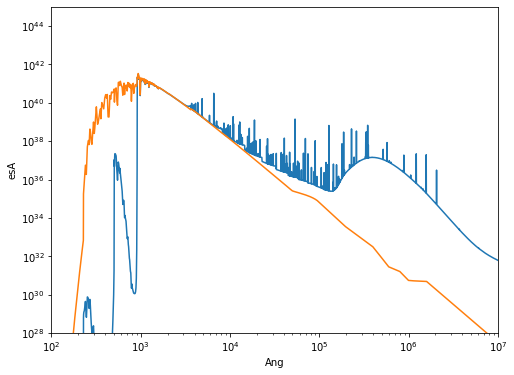

In [68]:
f, ax = plt.subplots(figsize=(8, 6))
M.plot_spectrum(xunit='Ang',cont='ntrans',yunit='esA', ax=ax)
M.plot_spectrum(xunit='Ang',cont='incid',yunit='esA', ax=ax)
ax.set_xlim((100, 1e7))
ax.set_ylim((1e28, 1e45));

In [61]:
M.emis_labels

array(['H__1_486133A', 'H__1_656281A', 'N__2_658345A', 'O__2_372603A',
       'O__2_372881A', 'O__3_500684A', 'S__2_673082A', 'S__2_671644A'],
      dtype='<U12')

## BPT diagram

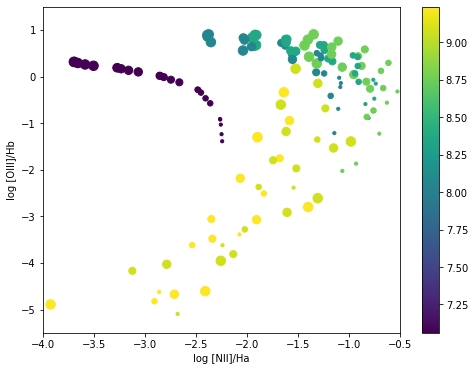

In [69]:
Has = np.array([M.get_emis_vol('H__1_656281A') for M in Ms])
Hbs = np.array([M.get_emis_vol('H__1_486133A') for M in Ms])    
N2s = np.array([M.get_emis_vol('N__2_658345A') for M in Ms])
O3s = np.array([M.get_emis_vol('O__3_500684A') for M in Ms])
T0s = np.array([M.T0 for M in Ms])
OoHs = np.array([M.abund['O'] for M in Ms])
logUs = np.array([M.log_U_mean_ne for M in Ms])
                             
f, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(np.log10(N2s/Has), np.log10(O3s/Hbs), c=12+OoHs, s=150+40*logUs)
cb = f.colorbar(sc, ax=ax)
ax.set_xlabel('log [NII]/Ha')
ax.set_ylabel('log [OIII]/Hb')
ax.set_xlim((-4, -0.5))
ax.set_ylim((-5.5, 1.5));

## building a dictionnary that holds all the models

In [63]:
models_dic = {M.model_name_s[3:]:M  for M in Ms}

## Effect of changing logU

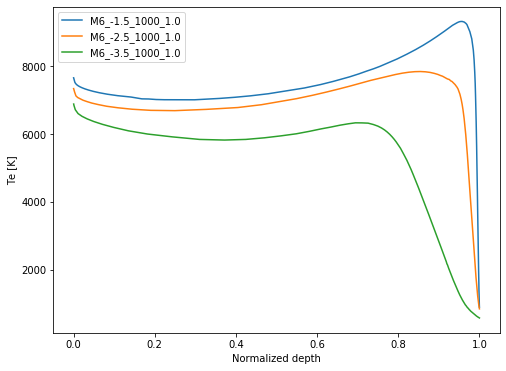

In [64]:
f, ax = plt.subplots(figsize=(8, 6))
names = ('-1.5_1000_1.0',
         '-2.5_1000_1.0',
         '-3.5_1000_1.0')
for name in names:
    M = models_dic[name]
    ax.plot(M.depth/M.depth[-1], M.te, label=M.model_name_s)
ax.legend()
ax.set_xlabel('Normalized depth')
ax.set_ylabel('Te [K]');

## Effect of changing age

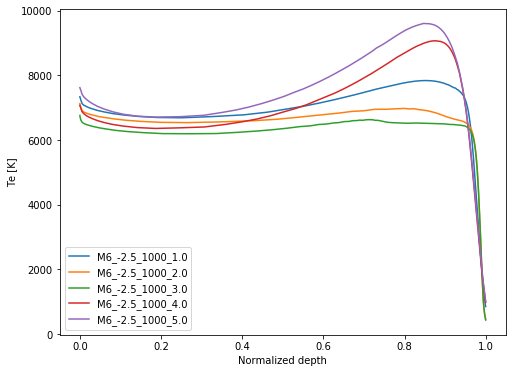

In [65]:
f, ax = plt.subplots(figsize=(8, 6))
names = ('-2.5_1000_1.0',
         '-2.5_1000_2.0',
         '-2.5_1000_3.0',
         '-2.5_1000_4.0',
         '-2.5_1000_5.0')
for name in names:
    M = models_dic[name]
    ax.plot(M.depth/M.depth[-1], M.te, label=M.model_name_s)
ax.legend()
ax.set_xlabel('Normalized depth')
ax.set_ylabel('Te [K]');

## Effect of changing metallicity

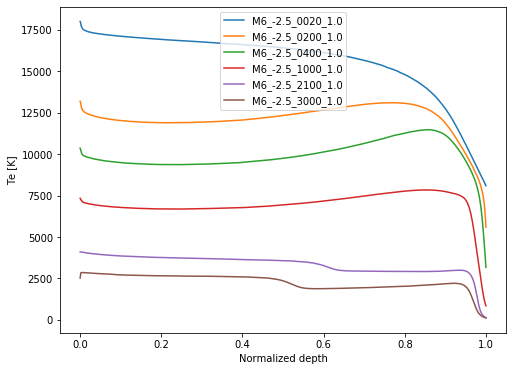

In [66]:
f, ax = plt.subplots(figsize=(8, 6))
names = ('-2.5_0020_1.0',
         '-2.5_0200_1.0',
         '-2.5_0400_1.0',
         '-2.5_1000_1.0',
         '-2.5_2100_1.0', 
         '-2.5_3000_1.0')
for name in names:
    M = models_dic[name]
    ax.plot(M.depth/M.depth[-1], M.te, label=M.model_name_s)
ax.legend()
ax.set_xlabel('Normalized depth')
ax.set_ylabel('Te [K]');